This file contains:

- definition of the quantification method based on the k-motif algorithm
- many experiments using the method
- evaluation of this and other methods using classifiers
- creation of plots showing the results

This code in this file is an extreme mess with very little encapsulation.

In [1]:
import collections
import math
import statistics
import random
import warnings

import numpy as np
import sklearn.model_selection, sklearn.naive_bayes, sklearn.tree, sklearn.neural_network, sklearn.neighbors, sklearn.ensemble
from scipy.optimize import minimize

import datasets
import sax
import seq

In [118]:
#n = 15  # size of subsequences
#overlap = 0  # overlap between subsequences
w = 15 # size of time bins
alpha = 10  # number of value bins
k = 10 # number of top motifs from each class to use for features

# n = 15  # size of subsequences
# overlap = 0.05  # overlap between subsequences
# w = 5  # size of time bins
# alpha = 10  # number of value bins
# k = 10 # number of top motifs from each class to use for features

In [448]:
ds_sr = datasets.load('2014_spatrel')
ds_sr_old = ds_sr
dev = random.sample(range(len(ds_sr_old.segment)),round(len(ds_sr_old.segment)*0.9))
out = [i for i in range(len(ds_sr_old.segment)) if i not in dev]
ds_sr = ds_sr_old.isel(segment=sorted(dev))
# ds_sr = ds_sr_old.sel(segment=sorted(out))

In [ ]:
prebins = {}

In [305]:
def set_prebins():
    vars = [('pos_abs',True), ('pos_rel',True), ('dist_object',False), ('dist_boundary', False)]
    for var, twod in vars:
        if twod:
            prebins[var] = {}
            prebins[var]['x'] = sax.bins(ds_sr[var].sel(component='x').data, alpha)
            prebins[var]['y'] = sax.bins(ds_sr[var].sel(component='y').data, alpha)
        else:
            prebins[var] = sax.bins(ds_sr[var].data, alpha)

In [307]:
set_prebins()

In [308]:
prebins

{'dist_boundary': array([ -4.13100738e-02,   7.53475015e+00,   1.29976226e+01,
          1.76654457e+01,   2.20283476e+01,   2.63912496e+01,
          3.10590727e+01,   3.65219451e+01,   4.40980053e+01]),
 'dist_object': array([ -3.45514804,   5.01728744,  11.12650951,  16.34661451,
         21.22572111,  26.10482771,  31.32493271,  37.43415478,  45.90659027]),
 'pos_abs': {'x': array([-49.20226447, -30.79657268, -17.52477396,  -6.1845113 ,
           4.41495947,  15.01443025,  26.3546929 ,  39.62649162,  58.03218341]),
  'y': array([-24.31490094,  -4.30948283,  10.11583112,  22.44173001,
          33.96245126,  45.48317251,  57.8090714 ,  72.23438535,  92.23980346])},
 'pos_rel': {'x': array([ -6.47572679e-01,  -4.25276185e-01,  -2.64984772e-01,
          -1.28021670e-01,  -5.55300927e-06,   1.28010564e-01,
           2.64973666e-01,   4.25265079e-01,   6.47561573e-01]),
  'y': array([ -7.11443398e-01,  -4.67249257e-01,  -2.91168101e-01,
          -1.40713245e-01,  -8.67095623e-05,   

In [205]:
def sax_nonumer(values, bins):
    return sax.sax(values, w, bins)#[:,0]

def var_sax(segments):
    vars = [('pos_abs',True), ('pos_rel',True), ('dist_object',False), ('dist_boundary', False)]
    if dict(vars)[segments.name]:
        bins = prebins[segments.name][str(segments.component.data)]
    else:
        bins = prebins[segments.name]
    return np.array([sax_nonumer(s, bins) for s in segments])
    
def myseq(values):
    return seq.grammar(values)

In [418]:
def get_2d_motifs(var, treatment):
    if treatment:
        x = var_sax(var.sel(component='x',segment=var.treatment==treatment))
        y = var_sax(var.sel(component='y',segment=var.treatment==treatment))
    else:
        x = var_sax(var.sel(component='x'))
        y = var_sax(var.sel(component='y'))
    xy = np.moveaxis(np.stack((x,y)), 0, -1).astype(int)
    return np.array([sax.numerosity(tuple(map(tuple,i)))[:,0] for i in xy])

def interest(o,r):
    I = {1: o * len(r) * len(set(r)),
         2: o * math.log(len(r)) * math.log(len(set(r))),
         3: math.log(o) * len(r) * math.log(len(set(r))),
         4: math.log(o) * math.log(len(r)) * len(set(r))}
    return I[2]
    
def get_2d_motif_scores(var, treatment):
    xy_num = get_2d_motifs(var, treatment)
    c = collections.Counter()
    for i in xy_num:
        for r in myseq(i).top(10000):
            c[tuple(r.expression)] += r.usage_count
    scores = [(interest(o,r),o,r) for r,o in c.items()]
    return sorted(scores,reverse=True)

def get_1d_motifs(var, treatment):
    if treatment:
        d = var_sax(var.sel(segment=var.treatment==treatment)).astype(int)
    else:
        d = var_sax(var).astype(int)
    return np.array([sax.numerosity(tuple(i))[:,0] for i in d])
    
def get_1d_motif_scores(var, treatment):
    num = get_1d_motifs(var, treatment)
    c = collections.Counter()
    for i in num:
        for r in myseq(i).top(10000):
            c[tuple(r.expression)] += r.usage_count
    scores = [(interest(o,r),o,r) for r,o in c.items()]
    return sorted(scores,reverse=True)

In [419]:
# ds_sr = ds_sr_old.isel(segment=dev)

# w = 25
# alpha = 10
# k = 10

# set_prebins()
# motif_scores_s = motif_scores(ds_sr, treatment='s')
# motif_scores_q = motif_scores(ds_sr, treatment='q')
# best_motifs_s = best_motifs(motif_scores_s)
# best_motifs_q = best_motifs(motif_scores_q)
# best_motifs_all = best_motifs_s + best_motifs_q
# features = get_feature_vectors2(ds_sr, best_motifs_all)    

# # create, train and score classifiers
# simple_classifiers = [sklearn.naive_bayes.GaussianNB,
#                       sklearn.tree.DecisionTreeClassifier,
#                       sklearn.neural_network.MLPClassifier,
#                       sklearn.neighbors.KNeighborsClassifier,
#                       sklearn.ensemble.RandomForestClassifier]

# X = features
# y = [t=='q' for t in ds_sr.treatment]

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     cv = sklearn.model_selection.StratifiedKFold(10,True)
#     results = []
#     for classifier in simple_classifiers:
#         c = classifier()
#         r = np.array([sklearn.model_selection.cross_val_score(c,X,y,cv=cv,scoring='f1_weighted') for _ in range(10)])
#         #print(classifier.__name__, r.mean(), r.std())
#         results.append(r.mean())
#     print(statistics.mean(results))

In [420]:
def motif_scores(ds, treatment):
    vars = [('pos_abs',True), ('pos_rel',True), ('dist_object',False), ('dist_boundary', False)]
    result = []
    for var, twod in vars:
        if twod:
            result.extend([m+(var,) for m in get_2d_motif_scores(ds[var], treatment)])
        else:
            result.extend([m+(var,) for m in get_1d_motif_scores(ds[var], treatment)])
    return result

In [421]:
def best_motifs(motif_scores):
    s = sorted(motif_scores, reverse=True, key=lambda r: r[:2])
    return s[:k]

In [422]:
motif_scores_s = motif_scores(ds_sr, treatment='s')
motif_scores_q = motif_scores(ds_sr, treatment='q')

1
1
1
1


In [423]:
best_motifs_s = best_motifs(motif_scores_s)
best_motifs_q = best_motifs(motif_scores_q)

In [424]:
best_motifs_all = best_motifs_s + best_motifs_q

In [425]:
sorted(best_motifs_all, reverse=True)

[(1374.5760728199743, 2861, (2, 3), 'dist_object'),
 (1199.691175753749, 2497, (3, 2), 'dist_object'),
 (933.5990127734599, 1226, (3, 2, 3), 'dist_object'),
 (790.3452078954414, 1645, ((0, 1), (0, 0)), 'pos_rel'),
 (631.7957133024348, 1315, ((0, 0), (0, 1)), 'pos_rel'),
 (618.3430289127252, 1287, ((1, 0), (0, 0)), 'pos_rel'),
 (597.6835493142426, 1244, (8, 9), 'dist_boundary'),
 (593.8399252028969, 1236, ((0, 0), (1, 0)), 'pos_rel'),
 (575.102257660087, 1197, (2, 1), 'dist_boundary'),
 (465.5589704867371, 969, (4, 3), 'dist_object'),
 (296.43950958753027, 617, (3, 2), 'dist_object'),
 (217.64521530494522, 453, (2, 3), 'dist_object'),
 (191.70075255336238, 399, (1, 0), 'dist_boundary'),
 (178.95250244842012, 235, (3, 2, 3), 'dist_object'),
 (173.9239910383889, 362, (0, 1), 'dist_boundary'),
 (140.772733078033, 293, ((0, 1), (0, 0)), 'pos_rel'),
 (140.2922800641148, 146, (1, 0, 1, 0), 'dist_boundary'),
 (139.33137403627842, 290, ((0, 0), (0, 1)), 'pos_rel'),
 (134.52684389709637, 280, (2

In [426]:
def motif_sim(motif1, motif2):
    motif1 = np.array(motif1).flatten()
    motif2 = np.array(motif2).flatten()
    small = motif1 if motif1.size < motif2.size else motif2
    large = motif1 if small is motif2 else motif2
    old_x = np.arange(small.size)
    new_x = np.arange(large.size) * small.size / large.size
    new = np.interp(new_x, old_x, small)
    dist =  sum(abs(new-large))
    max_dist = len(large) * alpha
    return 1 - dist / max_dist

def get_feature_vectors(ds, motifs):
    vars = [('pos_abs',True), ('pos_rel',True), ('dist_object',False), ('dist_boundary', False)]
    vectors = []
    for segment in ds.segment.data:
        d = ds.sel(segment=slice(segment,segment))
        data = {}
        for var,twod in vars:
            if twod:
                data[var] = get_2d_motif_scores(d[var], None)
            else:
                data[var] = get_1d_motif_scores(d[var], None)
        result = []
        for *motif, var in motifs:
            motif = motif[2]
            if data[var]:
                result.append(sum(motif_sim(motif, m[2])*m[1] for m in data[var][:]) / len(data[var][:]))
            else:
                result.append(0)
        vectors.append(result)
    return np.array(vectors)

In [427]:
def get_feature_vectors2(ds, motifs):
    vars = [('pos_abs',True), ('pos_rel',True), ('dist_object',False), ('dist_boundary', False)]
    vectors = []
    for segment in ds.segment.data:
        data = {}
        d = ds.sel(segment=slice(segment,segment+1))
        for var,twod in vars:
            if twod:
                data[var] = get_2d_motifs(d[var], None)
            else:
                data[var] = get_1d_motifs(d[var], None)
        vector = []
        for *motif, var in motifs:
            motif = motif[2]
            c = 0
            for i in range(len(data[var][0])-len(motif)+1):
                subseq = data[var][0][i:i+len(motif)]
                same = all(x == y for x,y in zip(motif,subseq))
                if same:
                    c += 1
            vector.append(c)
        vectors.append(vector)
    return np.array(vectors)

In [449]:

features = get_feature_vectors2(ds_sr, best_motifs_all)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [429]:
features[(ds_sr.treatment=='s').data].mean(0)

array([ 14.    ,  11.2375,  11.    ,   8.3375,  11.    ,   6.7375,
         7.1625,   6.8375,   6.7875,   6.4125,  11.2375,  14.    ,
         8.3375,   6.7375,   6.8375,   5.625 ,   3.7125,   5.5625,
         6.7875,   3.95  ])

In [430]:
features[(ds_sr.treatment=='q').data].mean(0)


array([ 40.73529412,  41.30147059,  12.38970588,  28.80882353,
        12.44117647,  20.95588235,   5.05147059,  20.125     ,
        15.26470588,  14.36764706,  41.30147059,  40.73529412,
        28.80882353,  20.95588235,  20.125     ,  17.40441176,
        17.41176471,  19.25      ,  15.26470588,  15.43382353])

In [431]:
# ds_sr.segment[ds_sr.treatment=='q']

<xarray.DataArray 'segment' (segment: 136)>
array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215])
Coordinates:
    part       (segment) int64 0 1 2 1 2 0 1 2 1 2 0 1 2 0 1 0 1 2 0 1 2 1 2 ...
    rat        (segment) object '109' '109' '109' '109' '109' '109' '109' ...
    session    (segment) object '

In [432]:
# d = np.concatenate((features[ds_sr.treatment=='q'],features[ds_sr.treatment=='s']))

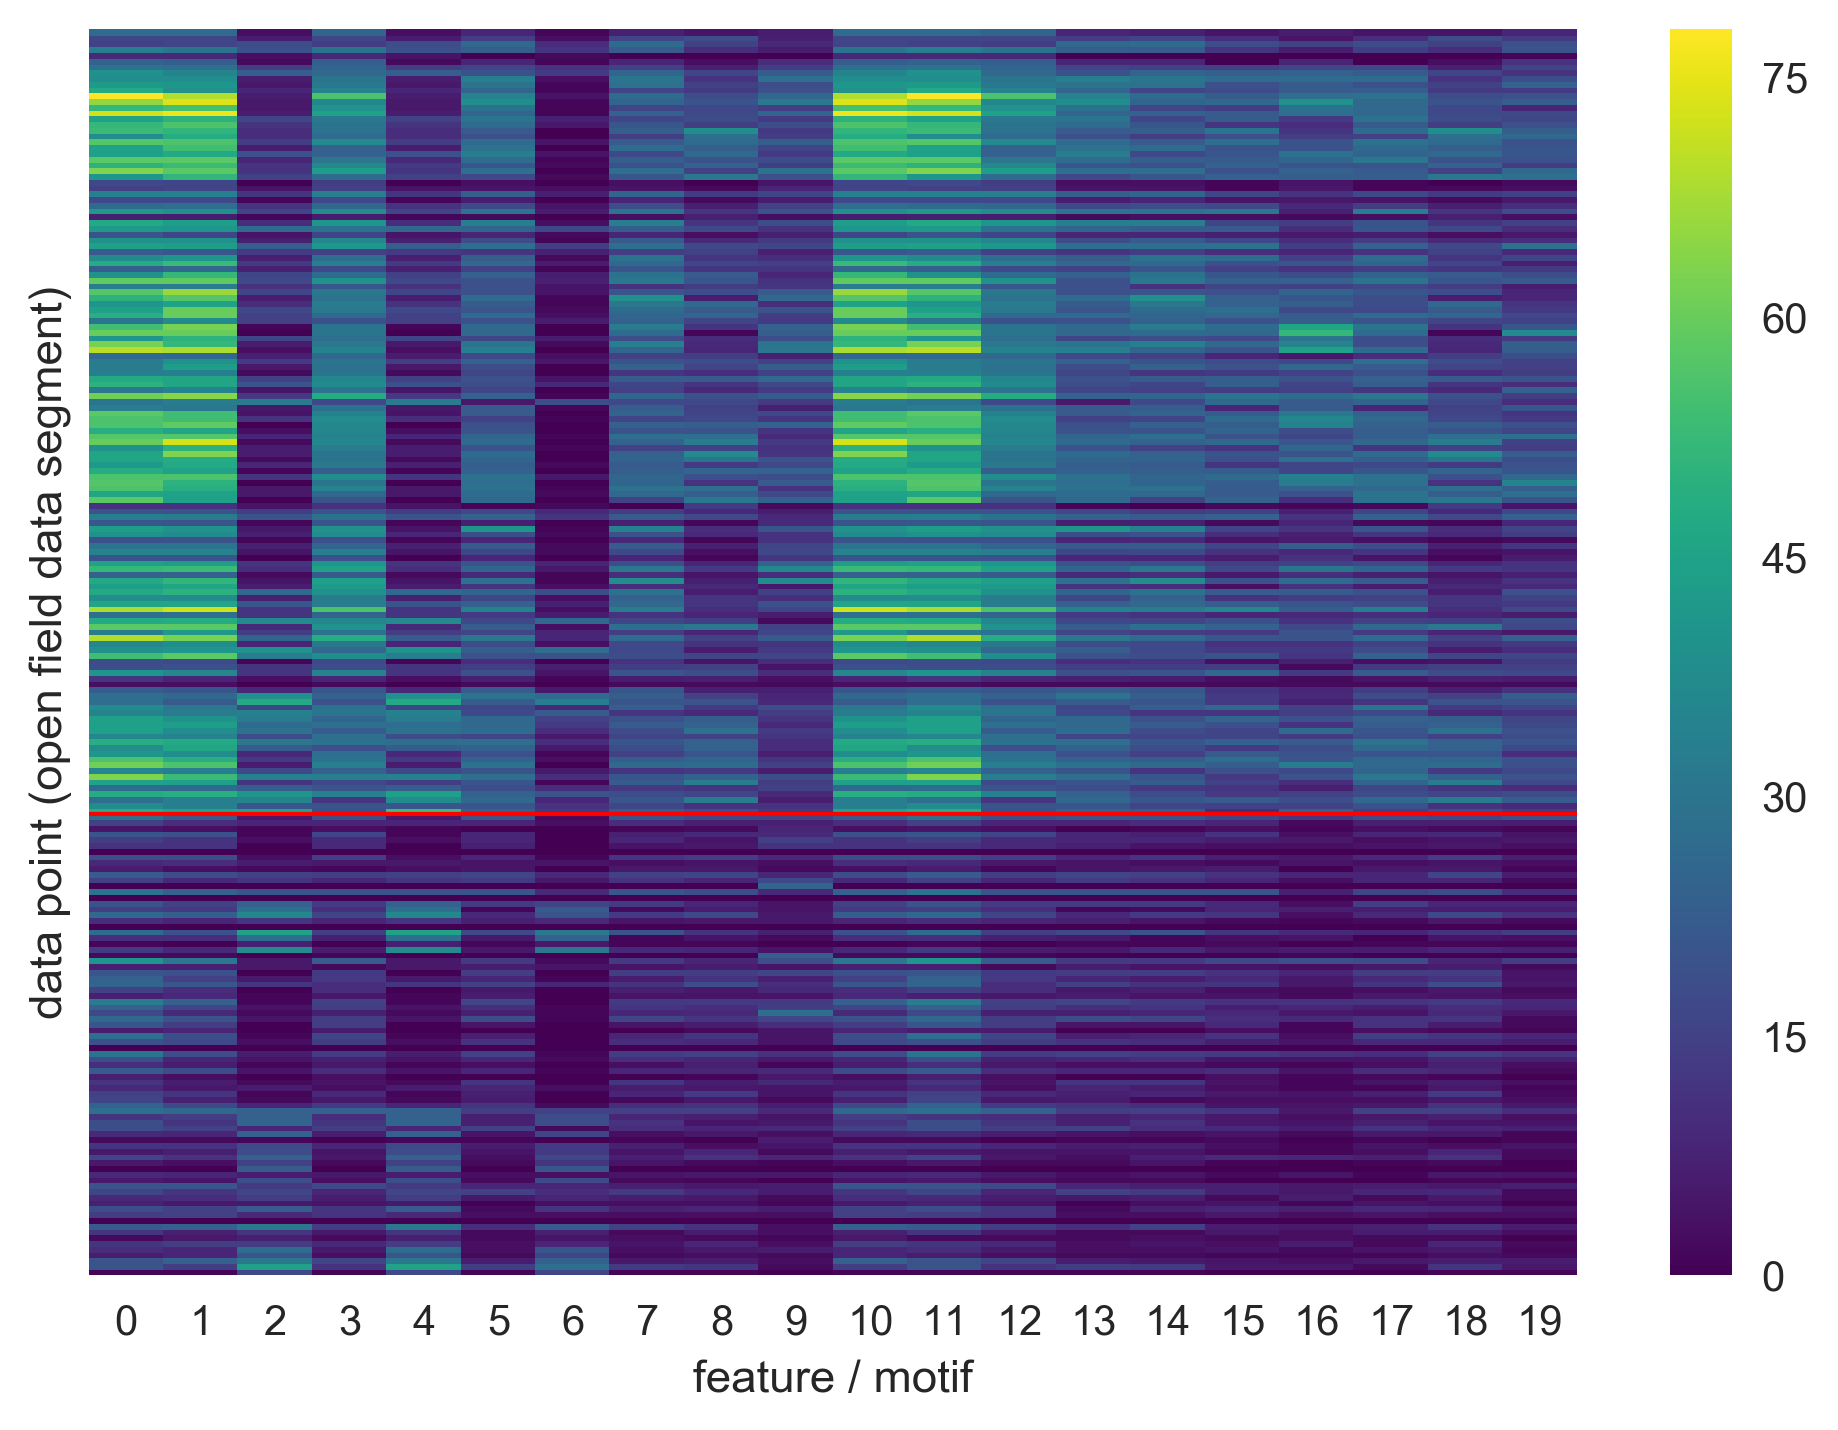

In [433]:
# fig, ax = plt.subplots(dpi=300)
# sns.heatmap(d,cmap='viridis',yticklabels=False,ax=ax)
# ax.hlines([80], *ax.get_xlim(), color='red', linewidth=1)
# ax.set_xlabel('feature / motif')
# ax.set_ylabel('data point (open field data segment)')

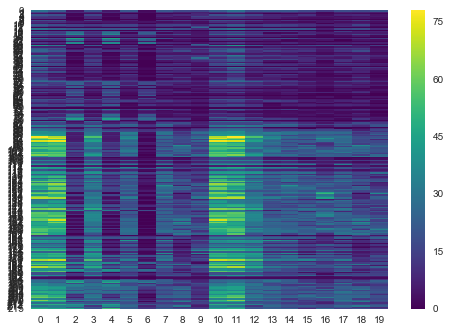

In [381]:
features.shape
sns.heatmap(features,cmap='viridis')

In [417]:
features[0]

array([29, 22,  5, 19,  5, 21,  2, 21, 17, 16, 22, 29, 19, 21, 21, 17, 13,
       18, 17, 20])

In [450]:
# create, train and score classifiers
simple_classifiers = [sklearn.naive_bayes.GaussianNB,
                      sklearn.tree.DecisionTreeClassifier,
                      sklearn.neural_network.MLPClassifier,
                      sklearn.neighbors.KNeighborsClassifier,
                      sklearn.ensemble.RandomForestClassifier
                      ]

X = features
y = ds_sr.treatment


cv = sklearn.model_selection.StratifiedKFold(10,True)
means = []
for classifier in simple_classifiers:
    c = classifier()
    r = sklearn.model_selection.cross_val_score(c,X,y,cv=cv,scoring='f1_weighted')
    print(classifier.__name__, r.mean(), r.std())
    means.append(r.mean())
#f'{statistics.mean(means)*100:.1f}'
statistics.mean(means), statistics.stdev(means)

GaussianNB 0.884820293541 0.0745077894333
DecisionTreeClassifier 0.871061771883 0.0856267977415


/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceW

MLPClassifier 0.695447525107 0.168328824404
KNeighborsClassifier 0.935555284048 0.0503090034222
RandomForestClassifier 0.917659786366 0.0436645929595


(0.86090893218891307, 0.09597531959395993)

In [304]:
I_1 = 85.2
I_2 = 85.4
I_3 = 79.5
I_4 = 81.8

In [11]:

    

def max_class_score(thew, thealpha, thek):
    global w, alpha, k
    w = int(round(thew))
    alpha = int(round(thealpha))
    k = int(round(thek))
    
    set_prebins()
    motif_scores_s = motif_scores(ds_sr, treatment='s')
    motif_scores_q = motif_scores(ds_sr, treatment='q')
    best_motifs_s = best_motifs(motif_scores_s)
    best_motifs_q = best_motifs(motif_scores_q)
    best_motifs_all = best_motifs_s + best_motifs_q
    features = get_feature_vectors2(ds_sr, best_motifs_all)    
    
    # create, train and score classifiers
    simple_classifiers = [sklearn.naive_bayes.GaussianNB,
                          sklearn.tree.DecisionTreeClassifier,
                          sklearn.neural_network.MLPClassifier,
                          sklearn.neighbors.KNeighborsClassifier,
                          sklearn.ensemble.RandomForestClassifier]

    X = features
    y = [t=='q' for t in ds_sr.treatment]

    cv = sklearn.model_selection.StratifiedKFold(10,True)
    results = []
    for classifier in simple_classifiers:
        c = classifier()
        r = sklearn.model_selection.cross_val_score(c,X,y,cv=cv,scoring='f1_weighted')
        #print(classifier.__name__, r.mean(), r.std())
        results.append(r.mean())
    return statistics.mean(results)

In [45]:
# random classifier:
# GaussianNB 0.625 0.0
# DecisionTreeClassifier 0.625 0.0
# MLPClassifier 0.625 0.0
# KNeighborsClassifier 0.375 0.0

In [46]:
#max_class_score(15, 0.5, 5, 5, 10)

In [532]:
def write(*x):
    with open('test.txt','a') as f:
        f.write(' '.join(str(i) for i in x)+'\n')

In [585]:
def f(x):
    try:
        s = statistics.mean(max_class_score(*x) for _ in range(3))
        write(x, s)
    except Exception as e:
        s = 0
        write(x, 'error')
        raise e
    return round(-s,2)

In [586]:
x0 = [15, 10, 10]
bounds = [(1,33), (3,30), (3,20)]
options = {'disp': True}
minimize(f, x0, options=options, callback=print, method='Nelder-Mead')

/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: Convergenc

[ 15.  10.  10.]


/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: Convergenc

/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[ 15.  10.  10.]


/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: Convergenc

[ 15.  10.  10.]


/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: Convergenc

[ 15.  10.  10.]


/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: Convergenc

[ 15.  10.  10.]


/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: Convergenc

/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


[ 15.  10.  10.]


/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: Convergenc

[ 15.  10.  10.]


/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: Convergenc

[ 15.  10.  10.]


/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: Convergenc

KeyboardInterrupt: 

In [589]:
import itertools

In [758]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    xs = [1,5,15,25,50,100,200]
    ys = [2,5,10,20]
    zs = [5,10,20]
    r = []
    for x,y,z in itertools.product(xs,ys,zs):
        s = statistics.mean(max_class_score(x,y,z) for _ in range(1))
        r.append([x,y,z,s])
        print(x,y,z,s)

1 2 5 0.737354575342
1 2 10 0.748720987685


KeyboardInterrupt: 

In [627]:
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

In [749]:
df = pd.DataFrame(r, columns=['w','alpha','k','score'])

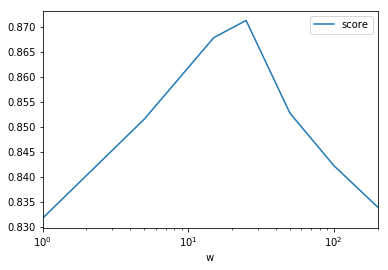

In [750]:
df.groupby('w').mean().plot(y='score',logx=True)
plt.show()

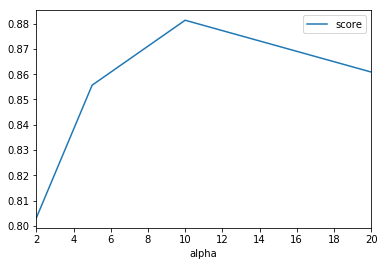

In [752]:
df.groupby('alpha').mean().plot(y='score')
plt.show()

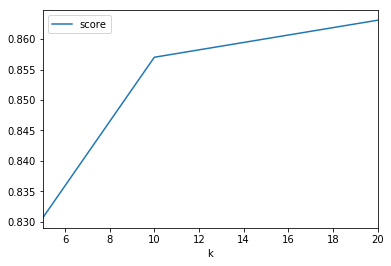

In [753]:
df.groupby('k').mean().plot(y='score')
plt.show()

In [766]:
df.groupby('w').mean()

,alpha,k,score
w,,,
1,9.25,11.666667,0.831763
5,9.25,11.666667,0.851616
15,9.25,11.666667,0.867930
25,9.25,11.666667,0.871362
50,9.25,11.666667,0.852799
100,9.25,11.666667,0.842313
200,9.25,11.666667,0.834009


In [764]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ws = [16,20,24,28]
    alphas = [12,14,18]
    ks = [10]
    r2 = []
    for w,alpha,k in itertools.product(ws,alphas,ks):
        s = statistics.mean(max_class_score(w,alpha,k) for _ in range(1))
        r2.append([w,alpha,k,s])
        print(w,alpha,k,s)

16 12 10 0.862392896826
16 14 10 0.870714389398
16 18 10 0.858026095163
20 12 10 0.866323691857
20 14 10 0.864445862496
20 18 10 0.881623671836
24 12 10 0.849677485901
24 14 10 0.870879942223
24 18 10 0.860608127594
28 12 10 0.85576704989
28 14 10 0.891200244343
28 18 10 0.878546773593


In [767]:
df2 = pd.DataFrame(r2, columns=['w','alpha','k','score'])

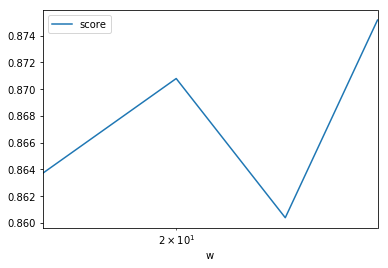

In [768]:
df2.groupby('w').mean().plot(y='score',logx=True)
plt.show()

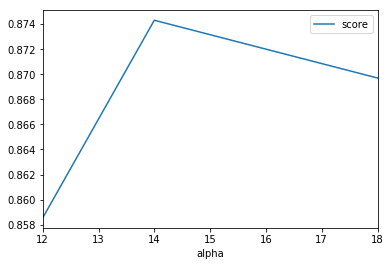

In [773]:
df2.groupby('alpha').mean().plot(y='score')
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  'left=%s, right=%s') % (left, right))


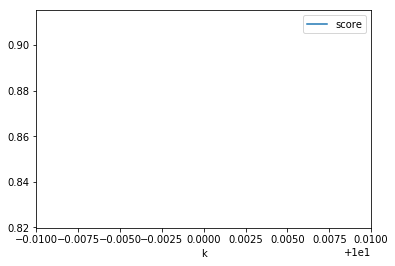

In [772]:
df2.groupby('k').mean().plot(y='score')
plt.show()

In [771]:
df2.groupby('alpha').mean()

,w,k,score
alpha,,,
12,22,10,0.858540
14,22,10,0.874310
18,22,10,0.869701


In [774]:
dfc = pd.concat([df,df2])

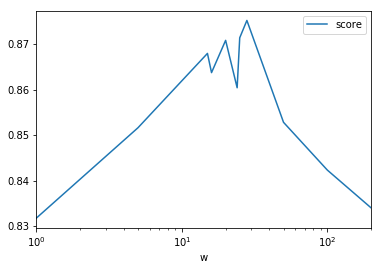

In [775]:
dfc.groupby('w').mean().plot(y='score',logx=True)
plt.show()

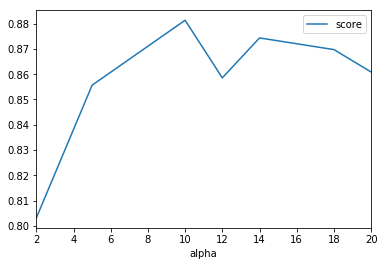

In [776]:
dfc.groupby('alpha').mean().plot(y='score')
plt.show()

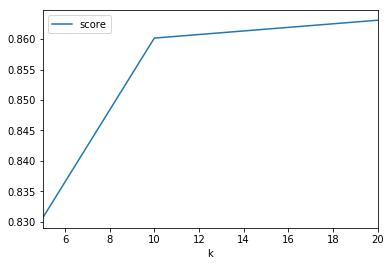

In [777]:
dfc.groupby('k').mean().plot(y='score')
plt.show()

In [780]:
dfc.groupby('alpha').mean()

,w,k,score
alpha,,,
2,56.571429,11.666667,0.803240
5,56.571429,11.666667,0.855651
10,56.571429,11.666667,0.881288
12,22.000000,10.000000,0.858540
14,22.000000,10.000000,0.874310
18,22.000000,10.000000,0.869701
20,56.571429,11.666667,0.860844


In [795]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ws = [26]
    alphas = [30,50,60,70,80,90,100,150,200,300,400,600,800,1000]
    ks = [10]
    r3 = []
    for w,alpha,k in itertools.product(ws,alphas,ks):
        s = statistics.mean(max_class_score(w,alpha,k) for _ in range(1))
        r3.append([w,alpha,k,s])
        print(w,alpha,k,s)

26 30 10 0.852784189382
26 50 10 0.83330440342
26 60 10 0.730333492241
26 70 10 0.704158917414
26 80 10 0.74127056407
26 90 10 0.75497104421
26 100 10 0.773299304421
26 150 10 0.740632939623
26 200 10 0.743065745239
26 300 10 0.760362502912
26 400 10 0.790756224837
26 600 10 0.820057578995
26 800 10 0.783023008637
26 1000 10 0.785027717474


In [796]:
df3 = pd.DataFrame(r3, columns=['w','alpha','k','score'])

/usr/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=26.0, right=26.0
  'left=%s, right=%s') % (left, right))


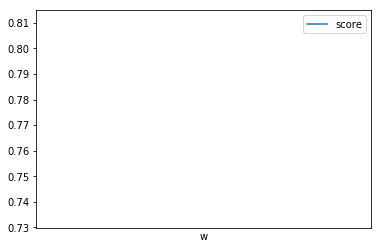

In [797]:
df3.groupby('w').mean().plot(y='score',logx=True)
plt.show()

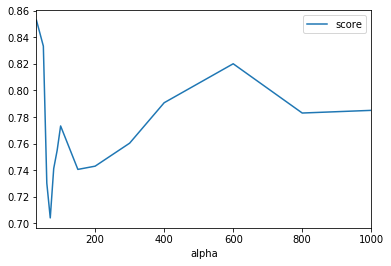

In [811]:
df3.groupby('alpha').mean().plot(y='score')
plt.show()

/usr/lib/python3.6/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10.0, right=10.0
  'left=%s, right=%s') % (left, right))


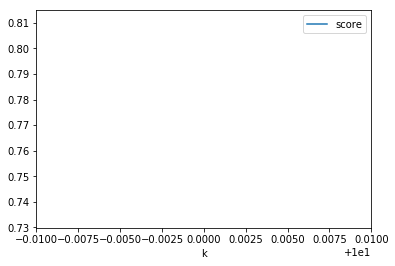

In [812]:
df3.groupby('k').mean().plot(y='score')
plt.show()

In [833]:
d = dfc.reset_index(drop=True).sort_values(['w','alpha','k','score'])
d[d.score == d.score.max()]

,w,alpha,k,score
44,25,10,20,0.915051


In [836]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ws = [25]
    alphas = [2**x for x in range(1,19)]
    ks = [10]
    g1 = []
    for w,alpha,k in itertools.product(ws,alphas,ks):
        s = statistics.mean(max_class_score(w,alpha,k) for _ in range(1))
        g1.append([w,alpha,k,s])
        print(w,alpha,k,s)

25 2 10 0.7858792005
25 4 10 0.80818629528
25 8 10 0.865944190824
25 16 10 0.882871838295
25 32 10 0.810412749233
25 64 10 0.780951513684
25 128 10 0.716253125973
25 256 10 0.763901578523
25 512 10 0.825981556043
25 1024 10 0.838663707771
25 2048 10 0.752441663207
25 4096 10 0.703275178471
25 8192 10 0.770177969169
25 16384 10 0.619164767083
25 32768 10 0.596001922288
25 65536 10 0.565344634077
25 131072 10 0.549248375814
25 262144 10 0.530051302158


KeyboardInterrupt: 

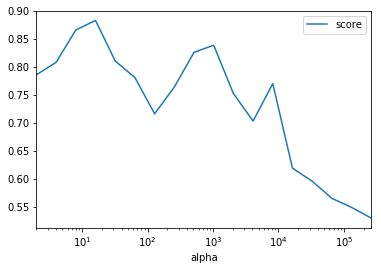

In [840]:
g1 = pd.DataFrame(g1, columns=['w','alpha','k','score'])
g1.groupby('alpha').mean().plot(y='score',logx=True)
plt.show()

In [846]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ws = [round(1.5**x) for x in range(0,19)]
    alphas = [10]
    ks = [10]
    g2 = []
    for w,alpha,k in itertools.product(ws,alphas,ks):
        s = statistics.mean(max_class_score(w,alpha,k) for _ in range(1))
        g2.append([w,alpha,k,s])
        print(w,alpha,k,s)

1 10 10 0.830689147059
2 10 10 0.846413694972
2 10 10 0.81981094765
3 10 10 0.815176551569
5 10 10 0.819564489671
8 10 10 0.841528221815
11 10 10 0.854848724328
17 10 10 0.85303109737
26 10 10 0.846144735762
38 10 10 0.874059547393
58 10 10 0.81122861297
86 10 10 0.847907181667
130 10 10 0.856195303497
195 10 10 0.820782677485
292 10 10 0.806063197455
438 10 10 0.81963027363
657 10 10 0.794028151114
985 10 10 0.801904772309
1478 10 10 0.749766426632


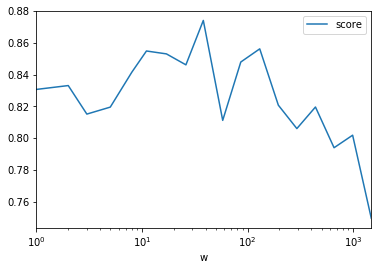

In [848]:
g2 = pd.DataFrame(g2, columns=['w','alpha','k','score'])
g2.groupby('w').mean().plot(y='score',logx=True)
plt.show()

In [849]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    ws = [25]
    alphas = [10]
    ks = [2**x for x in range(1,19)]
    g3 = []
    for w,alpha,k in itertools.product(ws,alphas,ks):
        s = statistics.mean(max_class_score(w,alpha,k) for _ in range(1))
        g3.append([w,alpha,k,s])
        print(w,alpha,k,s)

25 10 2 0.821205289312
25 10 4 0.82331458738
25 10 8 0.869835096411
25 10 16 0.85441344692
25 10 32 0.869787511499
25 10 64 0.855407371084
25 10 128 0.897107592468
25 10 256 0.884798297623
25 10 512 0.854739681678
25 10 1024 0.859982859746
25 10 2048 0.840215839733
25 10 4096 0.837743189724


KeyboardInterrupt: 

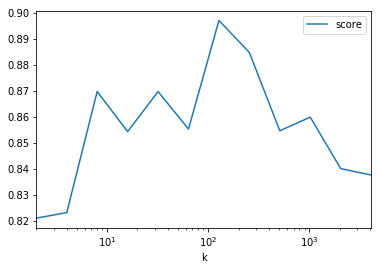

In [850]:
g3 = pd.DataFrame(g3, columns=['w','alpha','k','score'])
g3.groupby('k').mean().plot(y='score',logx=True)
plt.show()

In [877]:
ds_sr = ds_sr_old.isel(segment=dev)

w = 25
alpha = 10
k = 10

set_prebins()
motif_scores_s = motif_scores(ds_sr, treatment='s')
motif_scores_q = motif_scores(ds_sr, treatment='q')
best_motifs_s = best_motifs(motif_scores_s)
best_motifs_q = best_motifs(motif_scores_q)
best_motifs_all = best_motifs_s + best_motifs_q
features = get_feature_vectors2(ds_sr, best_motifs_all)    

# create, train and score classifiers
simple_classifiers = [sklearn.naive_bayes.GaussianNB,
                      sklearn.tree.DecisionTreeClassifier,
                      sklearn.neural_network.MLPClassifier,
                      sklearn.neighbors.KNeighborsClassifier,
                      sklearn.ensemble.RandomForestClassifier]

X = features
y = [t=='q' for t in ds_sr.treatment]

cv = sklearn.model_selection.StratifiedKFold(10,True)
results = []
for classifier in simple_classifiers:
    c = classifier()
    r = np.array([sklearn.model_selection.cross_val_score(c,X,y,cv=cv,scoring='f1_weighted') for _ in range(10)])
    #print(classifier.__name__, r.mean(), r.std())
    results.append(r.mean())
print(statistics.mean(results))

/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: Convergence

/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: 

0.85135310308


In [878]:
ds_sr = ds_sr_old.isel(segment=out)

features = get_feature_vectors2(ds_sr, best_motifs_all)    

# create, train and score classifiers
simple_classifiers = [sklearn.naive_bayes.GaussianNB,
                      sklearn.tree.DecisionTreeClassifier,
                      sklearn.neural_network.MLPClassifier,
                      sklearn.neighbors.KNeighborsClassifier,
                      sklearn.ensemble.RandomForestClassifier]

X = features
y = [t=='q' for t in ds_sr.treatment]

cv = sklearn.model_selection.StratifiedKFold(10,True)
results = []
for classifier in simple_classifiers:
    c = classifier()
    r = np.array([sklearn.model_selection.cross_val_score(c,X,y,cv=cv,scoring='f1_weighted') for _ in range(10)])
    #print(classifier.__name__, r.mean(), r.std())
    results.append(r.mean())
print(statistics.mean(results))

/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-s

/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWa

/usr/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-

0.857333333333


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
ds_sr_old

<xarray.Dataset>
Dimensions:        (component: 2, segment: 240, time: 15000)
Coordinates:
  * component      (component) object 'x' 'y'
    part           (segment) int64 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 ...
    rat            (segment) object '110' '110' '110' '110' '110' '110' ...
    session        (segment) object 'injection1' 'injection1' 'injection1' ...
  * time           (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
    treatment      (segment) object 's' 's' 's' 's' 's' 's' 's' 's' 's' 's' ...
    trial          (segment) object '5' '5' '5' '17' '17' '17' '29' '29' ...
Dimensions without coordinates: segment
Data variables:
    dist_boundary  (segment, time) float64 71.01 71.12 71.26 71.5 71.77 ...
    dist_object    (segment, time) float64 42.22 42.0 41.73 41.4 41.05 40.73 ...
    pos_abs        (segment, time, component) float64 -3.408 2.523 -3.288 ...
    pos_rel        (segment, time, component) float64 nan nan 0.1204 0.2022 ...

In [151]:
x0 = [15, 0.5, 5, 5, 10]
minx, maxx = x0[:], x0[:]
i = 0
minx[i] = 5
maxx[i] = 99
minv = f(*minx)
write(minx[i],minv)
maxv = f(*maxx)
write(maxx[i],maxv)
for _ in range(100):
    newx = x0[:]
    newx[i] = (minx[i]+maxx[i])/2
    newv = f(*newx)
    if minv > maxv:
        maxx = newx
        maxv = newv
    else:
        minx = newx
        maxv = newv
    write(newx[i],newv)

In [146]:
def f(*x):
    return -x[0]/2

In [644]:
rk = 100
#ds_sr = ds_sr_old.sel(segment=sorted(random.choices(ds_sr_old.segment,k=rk))).assign_coords(segment=range(rk))
ds_sr = ds_sr_old
#max_class_score(*x0)

In [199]:
ds_sr

<xarray.Dataset>
Dimensions:        (component: 2, segment: 100, time: 15000)
Coordinates:
  * component      (component) object 'x' 'y'
    part           (segment) int64 0 1 2 2 0 2 2 0 1 1 2 0 1 1 2 0 1 2 2 2 2 ...
    rat            (segment) object '110' '110' '110' '110' '110' '110' ...
    session        (segment) object 'injection3' 'injection4' 'injection4' ...
  * time           (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
    treatment      (segment) object 's' 's' 's' 's' 's' 's' 's' 's' 's' 's' ...
    trial          (segment) object '29' '41' '41' '65' '77' '77' '77' '89' ...
  * segment        (segment) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
Data variables:
    dist_boundary  (segment, time) float64 41.84 41.78 41.88 42.04 22.58 ...
    dist_object    (segment, time) float64 13.23 11.77 10.45 9.407 34.14 ...
    pos_abs        (segment, time, component) float64 16.65 38.77 15.08 ...
    pos_rel        (segment, time, component) float64 nan nan -1.575 0

In [271]:
def test(x):
    r = max_class_score(*x)
    write(x,r)
    
test([15, 0.5, 5, 5, 10])



In [62]:
ds_full.isel(segment=dev)

<xarray.Dataset>
Dimensions:      (segment: 216, time: 15000)
Coordinates:
    part         (segment) int64 2 0 2 1 2 2 1 2 0 2 2 2 0 0 2 1 1 0 0 1 2 1 ...
    rat          (segment) object '110' '117' '117' '109' '110' '109' '113' ...
    session      (segment) object 'injection3' 'injection4' 'injection5' ...
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
    treatment    (segment) object 's' 'q' 'q' 'q' 's' 'q' 'q' 'q' 'q' 'q' ...
    trial        (segment) object '29' '48' '60' '76' '101' '16' '104' '40' ...
Dimensions without coordinates: segment
Data variables:
    area         (time, segment) float64 68.61 73.76 56.07 83.12 66.29 43.02 ...
    areachange   (time, segment) float64 3.349 16.92 10.73 31.0 1.46 1.803 ...
    direction    (time, segment) float64 -130.3 56.33 37.4 109.9 -157.2 ...
    elongation   (time, segment) float64 0.784 0.7793 0.6395 0.7302 0.4951 ...
    time_offset  (segment) float64 8.52 9.0 7.04 7.56 8.2 7.72 8.2 7.68 6.4 ...
    x    

In [117]:
1# FULL DATA PERFORMANCE

# create, train and score classifiers
simple_classifiers = [sklearn.naive_bayes.GaussianNB,
                      sklearn.tree.DecisionTreeClassifier,
                      sklearn.neural_network.MLPClassifier,
                      sklearn.neighbors.KNeighborsClassifier,
                      sklearn.ensemble.RandomForestClassifier]

ds_full = datasets.load('2014_segments')

X = np.nan_to_num(np.array(ds_full.to_array()).T).reshape(240,-1)
y = np.array([t.data=='q' for t in ds_full.treatment])

cv = sklearn.model_selection.StratifiedKFold(10,True)
for classifier in simple_classifiers:
    r = []
    for _ in range(3):
        c = classifier()
        c.fit(X[dev],y[dev])
        p = c.predict(X[out])
        r.append(sklearn.metrics.f1_score(y[out],p,average='weighted'))
#     r = sklearn.model_selection.cross_val_score(c,X,y,cv=cv,scoring='f1_weighted')
    r = np.array(r)
    print(classifier.__name__, r.mean(), r.std())

GaussianNB 0.87386569873 0.0
DecisionTreeClassifier 0.72873028144 0.0452821834693


/usr/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


MLPClassifier 0.429824561404 0.0
KNeighborsClassifier 0.70987654321 0.0
RandomForestClassifier 0.840982764073 0.0558994587385


In [ ]:
# MEAN/STD DATA PERFORMANCE

# create, train and score classifiers
simple_classifiers = [sklearn.naive_bayes.GaussianNB,
                      sklearn.tree.DecisionTreeClassifier,
                      sklearn.neural_network.MLPClassifier,
                      sklearn.neighbors.KNeighborsClassifier,
                      sklearn.ensemble.RandomForestClassifier]

ds_full = datasets.load('2014_segments')

x = ds_full[['x','y']]
X = np.hstack((x.mean(dim='time').to_array().T, x.std(dim='time').to_array().T))
y = ds_full.treatment

cv = sklearn.model_selection.StratifiedKFold(10,True)
results = []
for classifier in simple_classifiers:
    c = classifier()
    r = sklearn.model_selection.cross_val_score(c,X,y,cv=cv,scoring='f1_weighted')
    #print(classifier.__name__, r.mean(), r.std())
    results.append(r.mean())
return statistics.mean(results)

<xarray.DataArray (segment: 240)>
array([ 63.499345,  60.356653,  58.924926, ...,  74.654307,  74.955308,
        75.691379])
Coordinates:
    part       (segment) int64 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 ...
    rat        (segment) object '110' '110' '110' '110' '110' '110' '110' ...
    session    (segment) object 'injection1' 'injection1' 'injection1' ...
    treatment  (segment) object 's' 's' 's' 's' 's' 's' 's' 's' 's' 's' 's' ...
    trial      (segment) object '5' '5' '5' '17' '17' '17' '29' '29' '29' ...
    variable   <U11 'area'
Dimensions without coordinates: segment

In [282]:
import itertools
t_pattern_features(ds_full.sel(segment=0).isel(time=slice(None,100)))

In [198]:
x = (ds_full.sel(segment=0)[['x','y']]/40).round()

In [177]:
ds_full.sel(segment=0).max()

<xarray.Dataset>
Dimensions:      ()
Data variables:
    area         float64 100.7
    areachange   float64 56.68
    direction    float64 180.0
    elongation   float64 0.8995
    time_offset  float64 8.04
    x            float64 84.77
    y            float64 78.46

In [311]:
all_sequences = collections.defaultdict(list)
import os
import xlrd
for filename in sorted(os.listdir('../data')):
    if '2014' in filename and not filename.startswith('.'):
        print(filename)
        wb = xlrd.open_workbook('../data/'+filename,on_demand=True)
        sheet = wb.sheet_by_name('Org.Data')
        rat = sheet.cell(31,1).value
        sheet = wb.sheet_by_name('Sequences')
        sequences = sheet.col_values(2)[1:]
        third = len(sequences)//3
        #all_sequences.append(sequences[third*ds.part:third*(ds.part+1)])
        all_sequences[rat].append(sequences)

2014_003.xlsx
2014_004.xlsx
2014_005.xlsx
2014_006.xlsx
2014_007.xlsx
2014_008.xlsx
2014_009.xlsx
2014_010.xlsx
2014_011.xlsx
2014_012.xlsx
2014_013.xlsx
2014_014.xlsx
2014_015.xlsx
2014_016.xlsx
2014_017.xlsx
2014_018.xlsx
2014_019.xlsx
2014_020.xlsx
2014_021.xlsx
2014_022.xlsx
2014_023.xlsx
2014_024.xlsx
2014_025.xlsx
2014_026.xlsx
2014_027.xlsx
2014_028.xlsx
2014_029.xlsx
2014_030.xlsx
2014_031.xlsx
2014_032.xlsx
2014_033.xlsx
2014_034.xlsx
2014_035.xlsx
2014_036.xlsx
2014_037.xlsx
2014_038.xlsx
2014_039.xlsx
2014_040.xlsx
2014_041.xlsx
2014_042.xlsx
2014_043.xlsx
2014_044.xlsx
2014_045.xlsx
2014_046.xlsx
2014_047.xlsx
2014_048.xlsx
2014_049.xlsx
2014_050.xlsx
2014_051.xlsx
2014_052.xlsx
2014_053.xlsx
2014_054.xlsx
2014_055.xlsx
2014_056.xlsx
2014_057.xlsx
2014_058.xlsx
2014_059.xlsx
2014_060.xlsx
2014_061.xlsx
2014_062.xlsx
2014_063.xlsx
2014_064.xlsx
2014_065.xlsx
2014_066.xlsx
2014_067.xlsx
2014_068.xlsx
2014_069.xlsx
2014_070.xlsx
2014_071.xlsx
2014_072.xlsx
2014_073.xlsx
2014_0

In [312]:
import pickle
pickle.dump(all_sequences, open("sequences.p", "wb"))

In [328]:
r = set()
for sequences in all_sequences.values():
    if sequences:
        r = r ^ set(sequences[0])

In [345]:
f = collections.defaultdict(list)
for rat, sequences in all_sequences.items():
    for sequence in sequences:
        v = []
        for x in r:
            v.append(sequence.count(x))
        f[rat].append(v)
list(f)

['108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '']

In [346]:
list(map(len,f.values()))

[11, 13, 13, 13, 13, 12, 13, 13, 13, 13, 12, 13, 1]

In [407]:
t_pat_features = []
for segment in ds_full.segment:
    rat = f[np.asscalar(segment.rat.data)]
    i = int(np.asscalar(segment.session.data).strip('injection'))-1
    s = rat[i]
    t_pat_features.append(s)

In [451]:
# T-PATTERN PERFORMANCE

# create, train and score classifiers
simple_classifiers = [sklearn.naive_bayes.GaussianNB,
                      sklearn.tree.DecisionTreeClassifier,
                      sklearn.neural_network.MLPClassifier,
                      sklearn.neighbors.KNeighborsClassifier,
                      sklearn.ensemble.RandomForestClassifier]

ds_full = datasets.load('2014_segments')

X = t_pat_features
y = ds_full.treatment

cv = sklearn.model_selection.StratifiedKFold(10,True)
for classifier in simple_classifiers:
    c = classifier()
    r = sklearn.model_selection.cross_val_score(c,X,y,cv=cv,scoring='f1_weighted')
    print(classifier.__name__, r.mean(), r.std())

NameError: name 't_pat_features' is not defined

In [223]:
import pickle
ar = pickle.load(open("sequences.p",'br'))

In [224]:
import itertools
import collections
import string
import numpy as np

In [225]:
dic = collections.defaultdict(int)
for a,b in itertools.product(string.ascii_uppercase,repeat=2):
    CODE = a+b
    for rat in ar.values():
        s = str(rat)
        dic[CODE] += s.count(CODE)
    

In [226]:
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

In [227]:
G = {k:v for k,v in dic.items() if v}

In [228]:
H = np.array(list(G.values()))

TypeError: slice indices must be integers or None or have an __index__ method

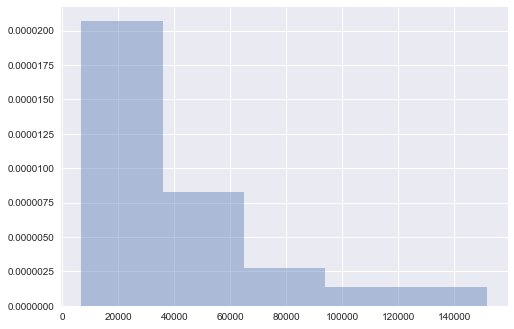

In [229]:
sns.distplot(H)

In [232]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm
import seaborn as sns
sns.set_style('white') 

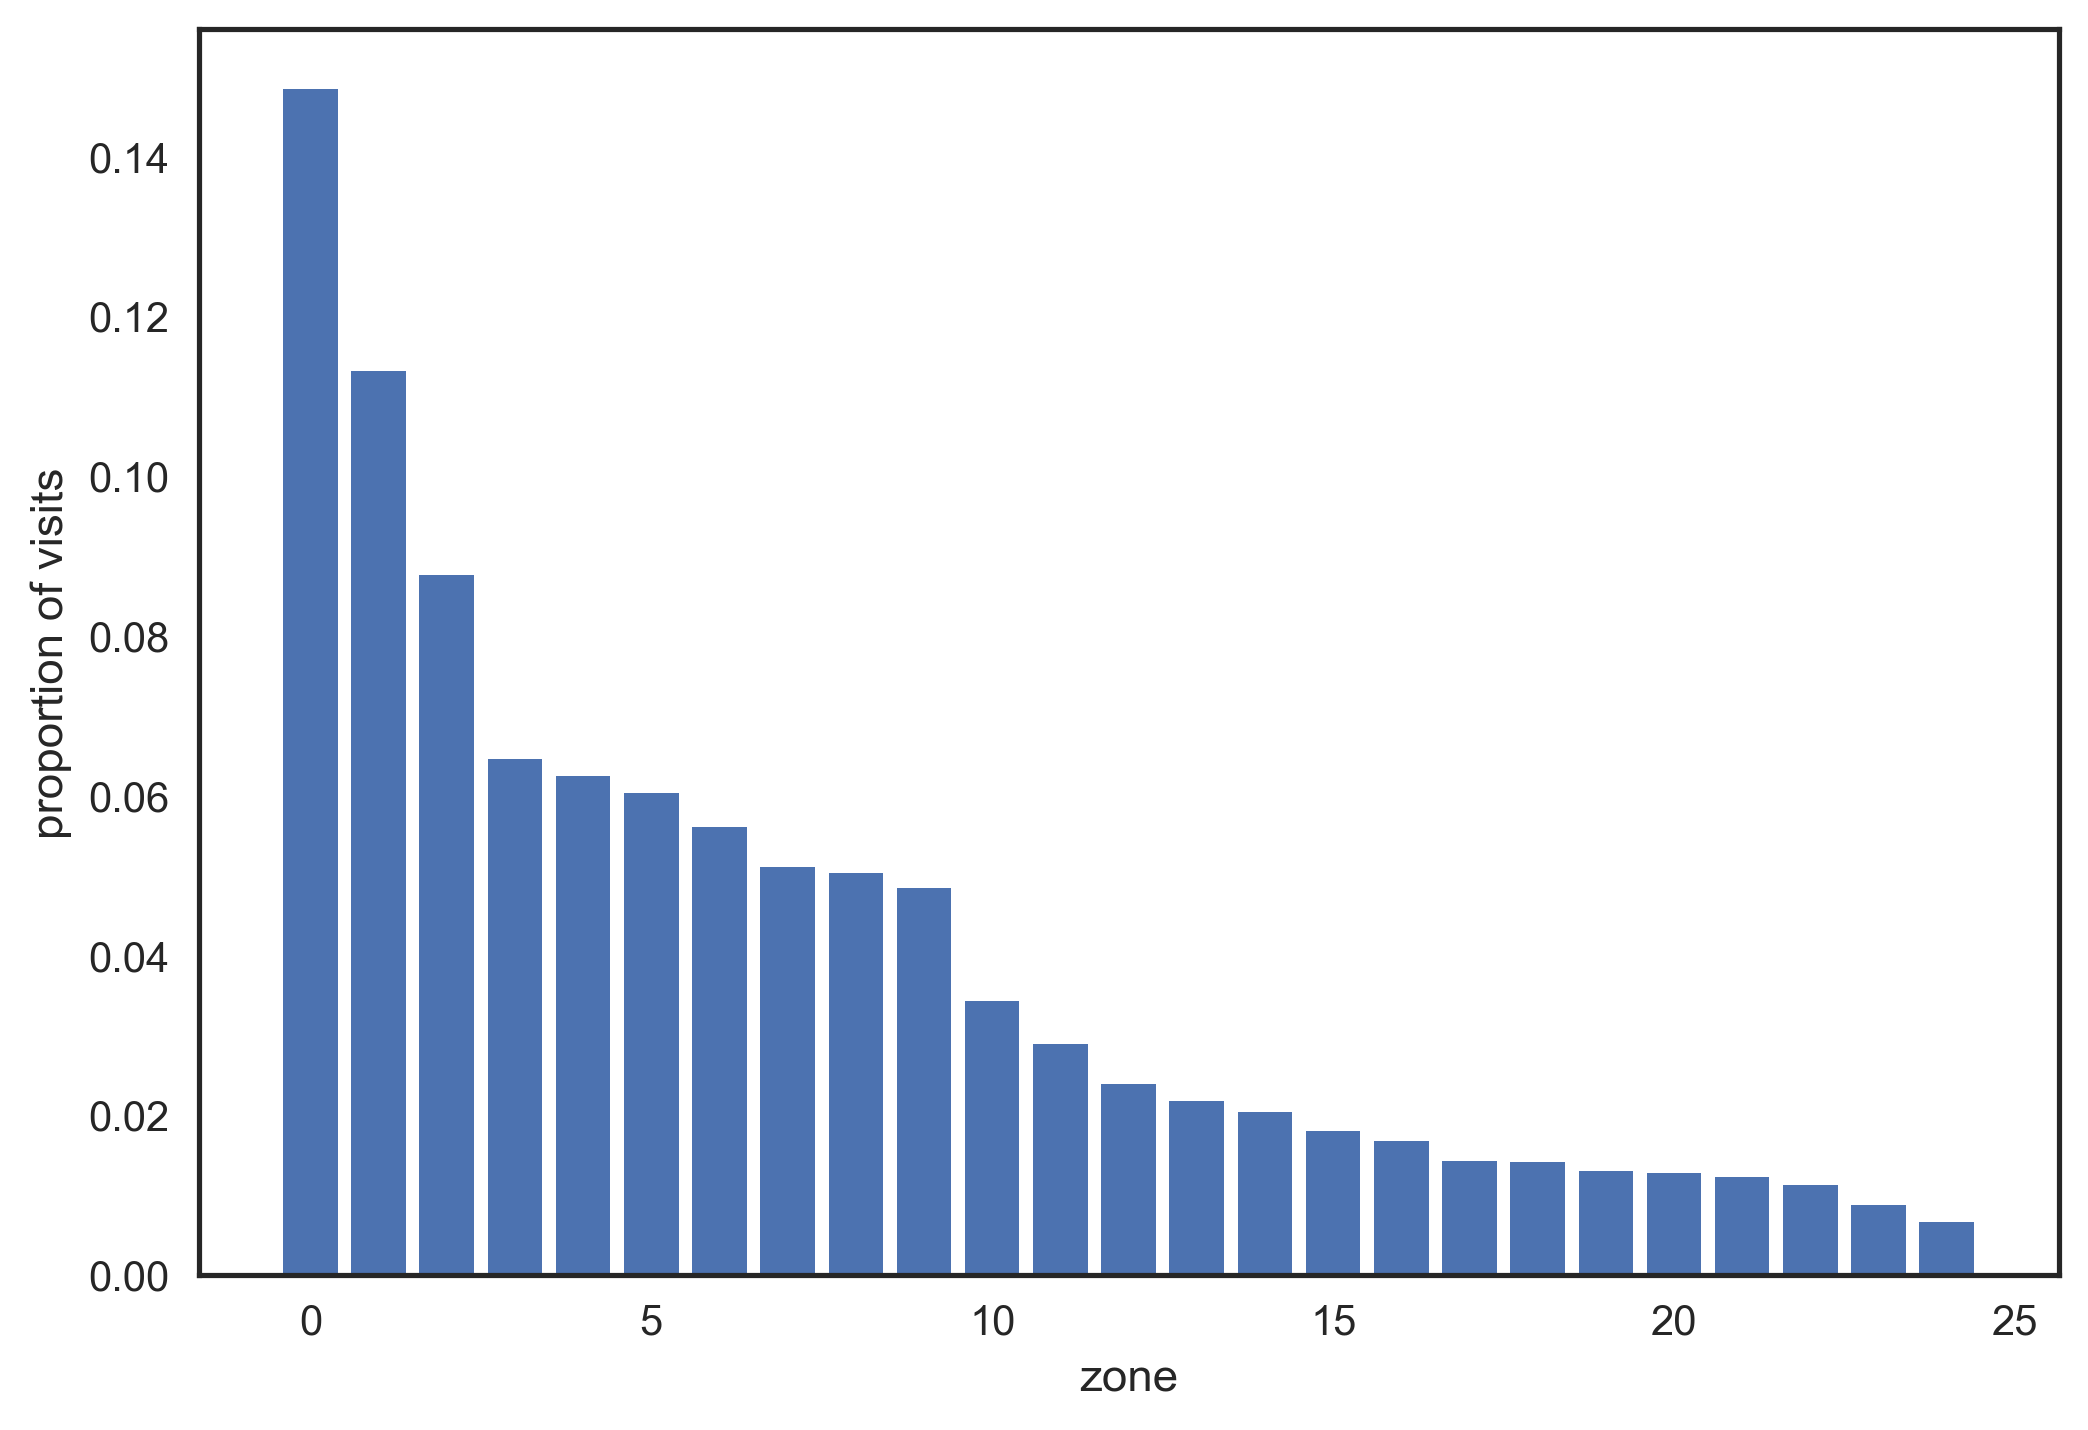

In [245]:
ax = plt.figure(dpi=300).add_subplot(111)
plt.viridis()
H = sorted(H,reverse=True)
ax.bar(range(len(H)),H/sum(H))
ax.set_xlabel('zone')
ax.set_xticks(range(len(H)),G.keys())
ax.set_ylabel('proportion of visits')

In [242]:
f'{H.var():.1e}'

'1.3e+09'

In [244]:
import scipy.stats
scipy.stats.entropy(H)

2.8972112256516804

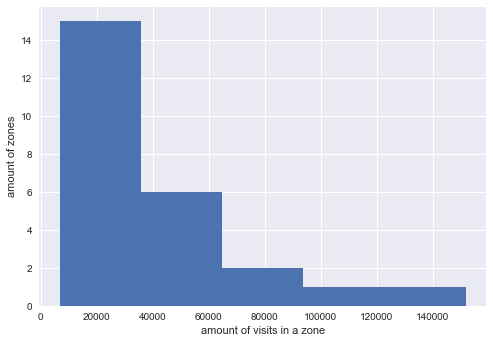

In [92]:
plt.viridis()
plt.hist(H, 5)
plt.xlabel('amount of visits in a zone')
plt.ylabel('amount of zones')

In [59]:
from scipy import stats

In [83]:
stats.kstest(H, 'uniform')

KstestResult(statistic=1.0, pvalue=0.0)

array([ 15.,   6.,   2.,   1.,   1.])

In [112]:
ds_jesse = datasets.load('2014features')

In [113]:
ds_jesse

<xarray.Dataset>
Dimensions:      (rat: 8, session: 10, time: 45001)
Coordinates:
  * rat          (rat) object '110' '112' '114' '109' '111' '113' '115' '117'
  * session      (session) object 'injection1' 'injection2' 'injection3' ...
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
    treatment    (rat) object 's' 's' 's' 'q' 'q' 'q' 'q' 'q'
    trial        (rat, session) object '5' '17' '29' '41' '53' '65' '77' ...
Data variables:
    area         (rat, session, time) float64 58.74 58.31 51.87 51.18 51.18 ...
    areachange   (rat, session, time) float64 14.86 13.48 12.28 11.85 12.71 ...
    bounarydist  (rat, session, time) float64 71.13 71.25 71.41 71.67 71.96 ...
    direction    (rat, session, time) float64 147.6 137.3 135.0 129.3 130.0 ...
    elongation   (rat, session, time) float64 0.7867 0.7429 0.7395 0.7292 ...
    object1dist  (rat, session, time) float64 67.22 67.26 67.32 67.34 67.34 ...
    object2dist  (rat, session, time) float64 42.22 42.0 41.7

In [118]:
import datetime
import pandas as pd

In [119]:
def segment_time(ds,segment_size=datetime.timedelta(minutes=10)):
    n_segments = int(np.ceil(ds.time[-1] / np.timedelta64(segment_size)))
    segment = range(n_segments)
    new_time = ds.time[:len(ds.time)//n_segments]
    ind = pd.MultiIndex.from_product((segment,new_time),names=('part','new_time'))
    r = ds.assign(time=ind).unstack('time').rename({'new_time':'time'})
    return r

In [165]:
ds_jesse_segment = segment_time(ds_jesse.isel(time=slice(None,-1)),datetime.timedelta(minutes=10))

In [166]:
ds_jesse_fin = ds_jesse_segment.stack(segment=('part','rat','session')).mean('time')

In [169]:
# JESSE PERFORMANCE

# create, train and score classifiers
simple_classifiers = [sklearn.naive_bayes.GaussianNB,
                      sklearn.tree.DecisionTreeClassifier,
                      sklearn.neural_network.MLPClassifier,
                      sklearn.neighbors.KNeighborsClassifier]

X = ds_jesse_fin.to_array().T
y = ds_jesse_fin.treatment

for classifier in simple_classifiers:
    c = classifier()
    r = sklearn.model_selection.cross_val_score(c,X,y,cv=10) # 10-fold cross validation
    print(classifier.__name__, r.mean(), r.std())

GaussianNB 0.766666666667 0.137183980276
DecisionTreeClassifier 0.7625 0.122261672926
MLPClassifier 0.704166666667 0.0821795121805
KNeighborsClassifier 0.779166666667 0.0913821341644


In [181]:
a = np.ones(25)
def split(a,n):
    return np.pad(a,(0,n-(len(a)%n)),'edge').reshape((-1,n))
split(a, 10)

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])